##**LOADING LIBRARIES**

In [ ]:
import keras
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import *
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import random

In [ ]:
import cv2
import numpy as np
import os
from keras.models import load_model
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from keras.preprocessing import image
from sklearn.metrics import classification_report


#**DECLARING VARIABLES VALUE**

In [ ]:
batch_size = 64
target_size = (224, 224)
seed = random.randint(1, 1000)
learning_rate = 0.0001

#**SETTING PATH**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/CS114/predict_food/data_split/data_train'  
test_path = '/content/drive/MyDrive/CS114/predict_food/data_split/data_test'
model_path = '/content/drive/MyDrive/CS114/predict_food/best_model/best_model.h5'
history_path = '/content/drive/MyDrive/CS114/predict_food/history/training.csv'

class_names_visual = os.listdir(train_path)


#**PREPARING DATASET**

In [ ]:
train_datagen = ImageDataGenerator(shear_range=0.1,
                                   rotation_range = 90,
                                   brightness_range = [0.7, 1.1],
                                   validation_split = 0.15)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224, 224),
                                                    batch_size= batch_size,
                                                    shuffle=False,
                                                    seed = seed,
                                                    class_mode='categorical',
                                                    subset = 'training')

valid_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed = seed,
                                                    class_mode='categorical',
                                                    subset = 'validation')

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  seed = seed,
                                                  shuffle=False,
                                                  class_mode='categorical')    
class_names = list(valid_generator.class_indices.keys())

Found 15785 images belonging to 30 classes.
Found 2767 images belonging to 30 classes.
Found 4626 images belonging to 30 classes.


#**TRAINING MODEL**

In [ ]:
def create_model():
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu', input_shape= (224,224,3)))
    model.add(tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size= (2,2), strides= 2))

    model.add(tf.keras.layers.Conv2D(filters= 128, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.Conv2D(filters= 128, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size= (2,2), strides= 2))

    model.add(tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size= (2,2), strides= 2))

    model.add(tf.keras.layers.Conv2D(filters= 512, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.Conv2D(filters= 512, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.Conv2D(filters= 512, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size= (2,2), strides= 2))

    model.add(tf.keras.layers.Conv2D(filters= 512, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.Conv2D(filters= 512, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.Conv2D(filters= 512, kernel_size= 3, strides= 1, padding= 'same', activation= 'relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size= (2,2), strides= 2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units= 4096, activation= 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units= 4096, activation= 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units= 30, activation= 'softmax'))
    return model
model.summary()

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate = 0.0001), 
              metrics=["accuracy"])

In [ ]:
reduce = ReduceLROnPlateau(monitor='val_loss', 
                       factor = 0.1, 
                       patience = 10, 
                       min_lr = 0.0000001) #giảm lr nếu ko cải thiện

earlyStop = EarlyStopping(monitor='val_accuracy', 
                          mode='max', 
                          verbose=1, 
                          patience=10) #dừng model nếu ko cải thiện

history = CSVLogger('/content/drive/MyDrive/CS114/predict_food/history2/training.csv')

checkPoint = ModelCheckpoint(model_path, 
                     monitor='val_accuracy', 
                     mode='max', 
                     save_best_only=True)

In [ ]:
H = model.fit(train_generator, 
              validation_data = valid_generator, 
              epochs = 100, 
              verbose = 1, 
              callbacks = [checkPoint, earlyStop, history, reduce])

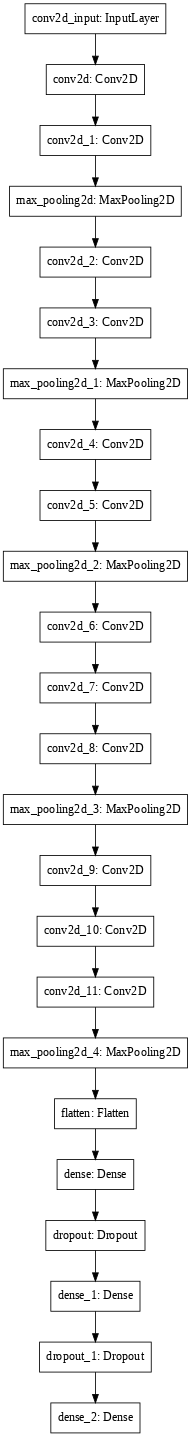

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CS114/predict_food/best_model/best_model.h5')
tf.keras.utils.plot_model(model, dpi=60)

#**EVALUATION**

## **I. Accuracy:**

In [ ]:
acc_valid = model.evaluate(valid_generator)
acc_train = model.evaluate(train_generator)
acc_test = model.evaluate(test_generator)


73/73 [==============================] - 2152s 29s/step - loss: 1.5983 - accuracy: 0.6232


In [ ]:
print("Train accuracy: ", acc_train[1])
print("Valid accuracy: ", acc_valid[1])
print("Test accuracy: ", acc_test[1])

Train accuracy:  0.8729806542396545
Valid accuracy:  0.6208890676498413
Test accuracy:  0.6232166290283203


## **II. Classification report:**

In [ ]:
predict = model.predict(test_generator)
predicts = np.argmax(predict, axis = 1)

print(classification_report(test_generator.classes, predicts, target_names = class_names))

                  precision    recall  f1-score   support

        banh_beo       0.60      0.83      0.70       118
    banh_bot_loc       0.43      0.19      0.27       144
        banh_can       0.51      0.53      0.52       148
       banh_cuon       0.55      0.69      0.61       228
        banh_gio       0.62      0.50      0.55       128
       banh_khot       0.66      0.54      0.60       167
         banh_mi       0.93      0.83      0.88       267
   banh_mi_nuong       0.54      0.30      0.38        84
banh_trang_nuong       0.53      0.57      0.55       159
 banh_trang_tron       0.57      0.50      0.53        98
        banh_xeo       0.79      0.67      0.73       234
         bap_xao       0.84      0.67      0.75       121
       bot_chien       0.46      0.53      0.49       135
      bun_bo_hue       0.66      0.77      0.71       306
         bun_cha       0.54      0.66      0.59       102
 bun_dau_mam_tom       0.75      0.84      0.80       185
  bun_thit_nu

##**III. Confusion matrix:**

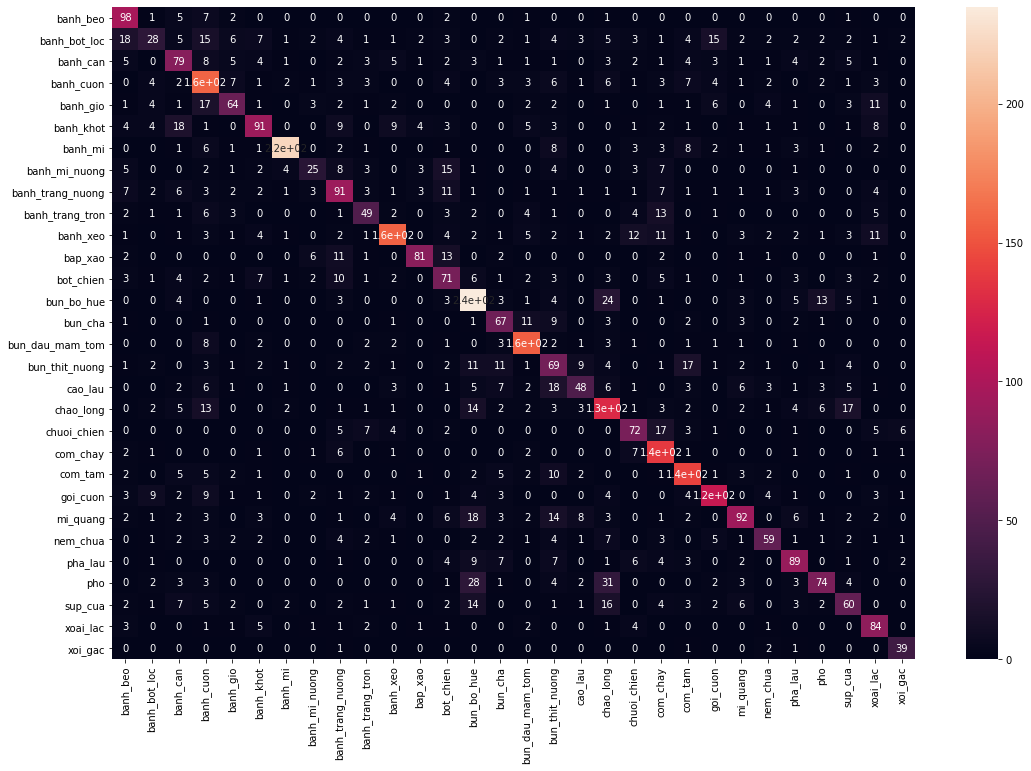

In [ ]:
matrix = np.array(tf.math.confusion_matrix(test_generator.classes, predicts))

df_cm = pd.DataFrame(matrix, 
                  index = valid_generator.class_indices.keys() ,
                  columns = valid_generator.class_indices.keys())
plt.figure(figsize = (18,12))
sn.heatmap(df_cm, annot=True)

## **IV. History plot:**

In [ ]:
def display_history(history): 
  plt.style.use('fivethirtyeight')

  plt.figure(figsize=(22,12), edgecolor= 'black')
  plt.subplot(1, 2, 1)
  plt.suptitle('Optimizer : Adam', fontsize=20, c = 'black')
  plt.xlabel('Epochs', fontsize=16, c= 'black')
  plt.ylabel('Loss', fontsize=16, c= 'black')
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.legend(loc='upper right')

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs', fontsize=16, c= 'black')
  plt.ylabel('Accuracy', fontsize=16, c= 'black')
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.show()

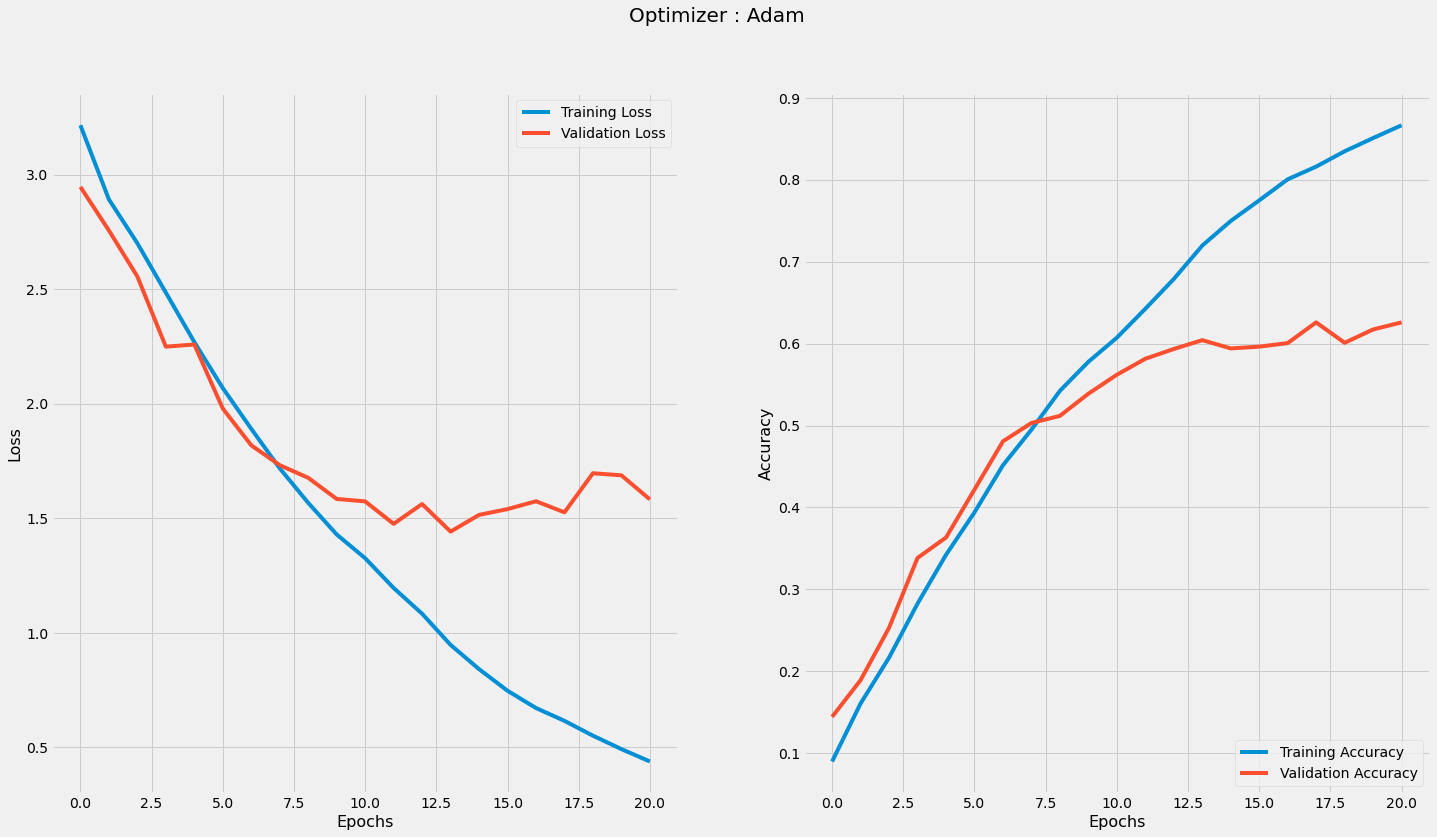

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/CS114/predict_food/history/training.csv')
display_history(history= history)

#**PREDICTION**

In [ ]:
def prediction(path, model):
  img=image.load_img(path, target_size=(224, 224))
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  predict = model.predict(x)

  return class_names[np.argmax(predict)], str(int(max(predict[0])*10000)/100)

In [ ]:
def test_predict(cols, rows, test_path):
  fig = plt.figure(figsize = (28,17))
  i = 0
  for name_true in class_names:
    path = test_path + '/' + name_true +'/' + name_true +'_'+ str(random.randint(1,44)) + '.jpg'
    image = plt.imread(path)
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.axis('off')
    name, ability = prediction(path, model)
    plt.title("True: "+ name_true +"\nPredict: " +name + " " + ability +"%")
    i = i+1

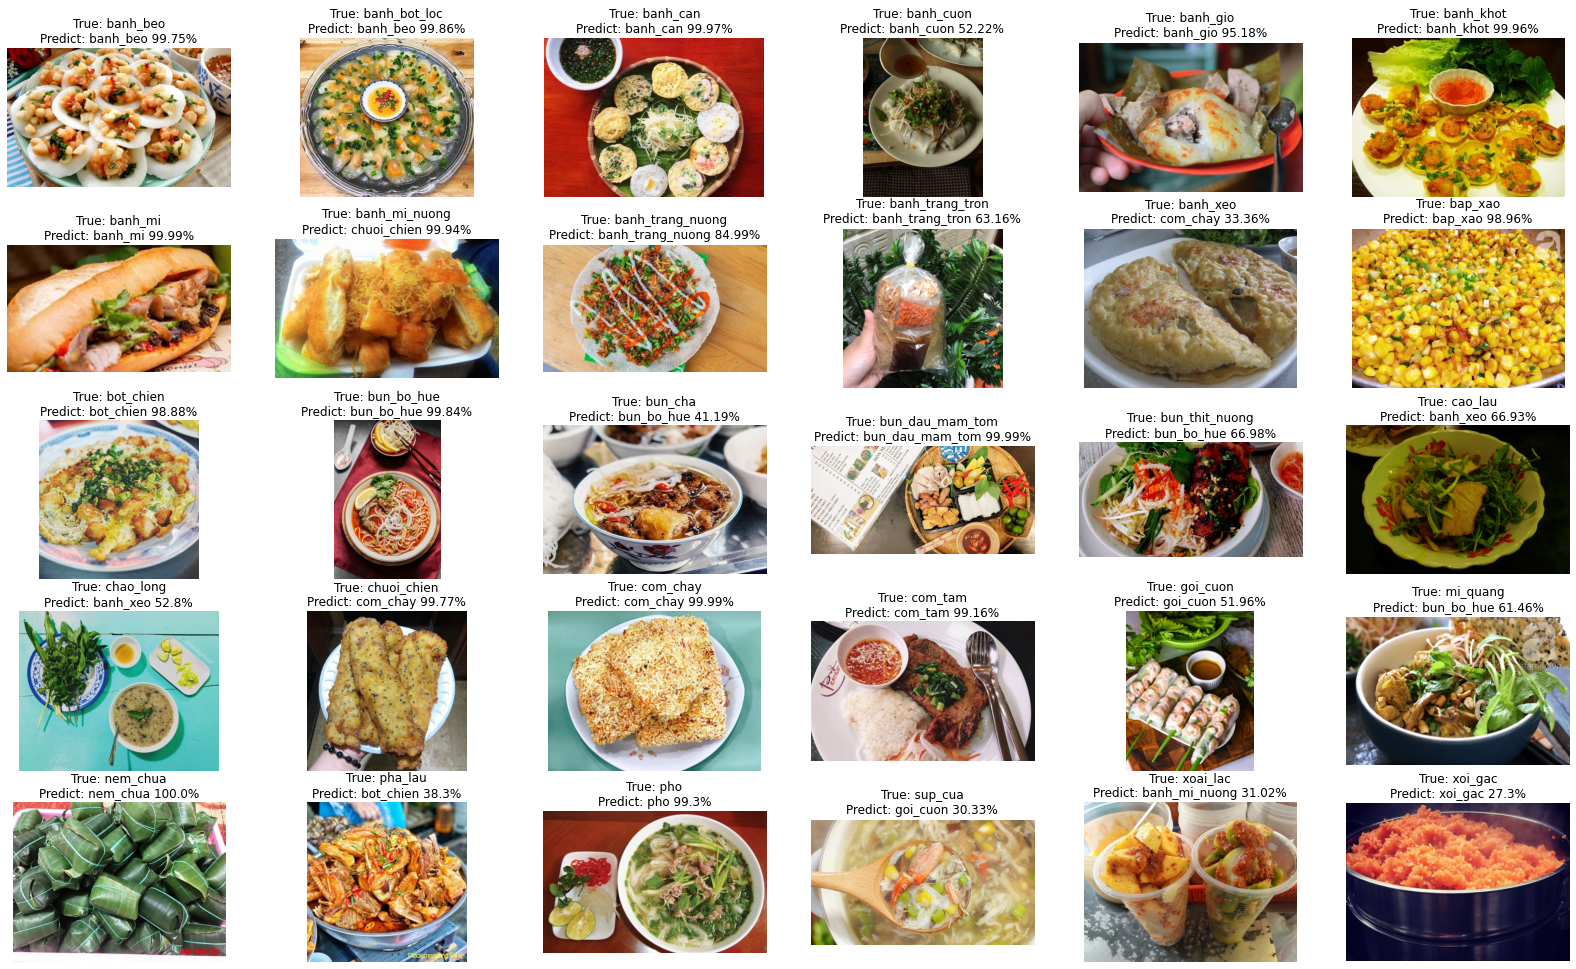

In [ ]:
test_predict(6, 5, test_path)